# Cyclical features in time series forecasting

Cyclical features play an important role in time series prediction because they capture recurring patterns or oscillations within a data set. These patterns repeat at fixed intervals, and effective incorporation of cyclical features into a machine learning model requires careful pre-processing and feature engineering.

Due to the circular nature of cyclical features, it is not recommended to use them directly as numerical inputs in a machine learning model. Instead, they should be encoded in a format that captures their cyclical behaviour. There are several common encoding techniques:

+ One-hot encoding: If the cyclical feature consists of distinct categories, such as seasons or months, one-hot encoding can be used. This approach creates binary variables for each category, allowing the model to understand the presence or absence of specific categories.

+ Trigonometric coding: For periodic features such as time of day or day of week, trigonometric functions such as sine and cosine can be used for coding. By mapping the cyclic feature onto a unit circle, these functions preserve the cyclic relationships. In addition, this method introduces only two additional features, making it an efficient coding technique.

+ Basis functions: Basis functions are mathematical functions that span a vector space and can be used to represent other functions within that space. When using basis functions, the cyclic feature is transformed into a new set of features based on the chosen basis functions. Some commonly used basis functions for encoding cyclic features include Fourier basis functions, B-spline basis functions, and Gaussian basis functions. B-splines are a way of approximating non-linear functions using a piecewise combination of polynomials.

By applying these encoding techniques, cyclic features can be effectively incorporated into a machine learning model, allowing it to capture and exploit the valuable recurring patterns present in time series data.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">🖉 Note</b>
</p>

The following examples are is inspired by <a href="https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py">Time-related feature engineering</a>, <a href="https://scikit-lego.netlify.app/preprocessing.html#Repeating-Basis-Function-Transformer">scikit-lego’s documentation</a> and <a href="https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/">Three Approaches to Encoding Time Information as Features for ML Models By Eryk Lewinson</a>.
</div>

## Libraries

In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import make_column_transformer
from sklego.preprocessing import RepeatingBasisFunction
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Data

In [3]:
# Data simulation
# ==============================================================================
np.random.seed(123)
dates = pd.date_range(start="2020-01-01", end="2023-12-31")
data = pd.DataFrame(index=dates)
data.index.name = "date"
data["day_idx"] = range(len(data))
data['month'] = data.index.month

# Create the components that will be combined to get the target series
signal_1 = 3 + 4 * np.sin(data["day_idx"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(data["day_idx"] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.85, len(data))
y = signal_1 + signal_2 + noise

data["y"] = y
data = data[["y", "month"]]
data.head(3)

,y,month
date,,
2020-01-01,2.928244,1
2020-01-02,4.866145,1
2020-01-03,4.425159,1


In [4]:
# Split train-test
# ==============================================================================
end_train = '2022-06-30 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train : 2020-01-01 00:00:00 --- 2022-06-30 00:00:00  (n=912)
Dates test  : 2022-07-01 00:00:00 --- 2023-12-31 00:00:00  (n=549)


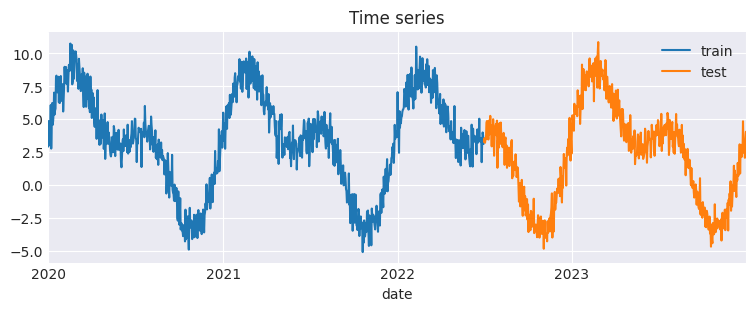

In [5]:
# Plot time series
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 3))
data_train['y'].plot(title="Time series", label="train", ax=ax)
data_test['y'].plot(title="Time series", label="test", ax=ax)
ax.legend();

## One hot encoding

In [6]:
# One hot encoding of week_day and hour_day
# ==============================================================================
one_hot_encoder = make_column_transformer(
                        (
                            OneHotEncoder(sparse_output=False, drop='if_binary'),
                            ['month'],
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

data_encoded_oh = one_hot_encoder.fit_transform(data)
data_encoded_oh.head(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,y
date,,,,,,,,,,,,,
2020-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.928244
2020-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.866145
2020-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.425159


## Sine-Cosine encoding

In [7]:
# Cyclical encoding with sine/cosine transformation
# ==============================================================================
def sin_transformer(period):
	"""
	Returns a transformer that applies sine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	"""
	Returns a transformer that applies cosine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

data_encoded_sin_cos = data.copy()
data_encoded_sin_cos["month_sin"] = sin_transformer(12).fit_transform(data_encoded_sin_cos['month'])
data_encoded_sin_cos["month_cos"] = cos_transformer(12).fit_transform(data_encoded_sin_cos['month'])
data_encoded_sin_cos.head()

,y,month,month_sin,month_cos
date,,,,
2020-01-01,2.928244,1,0.5,0.866025
2020-01-02,4.866145,1,0.5,0.866025
2020-01-03,4.425159,1,0.5,0.866025
2020-01-04,3.069222,1,0.5,0.866025
2020-01-05,4.021290,1,0.5,0.866025


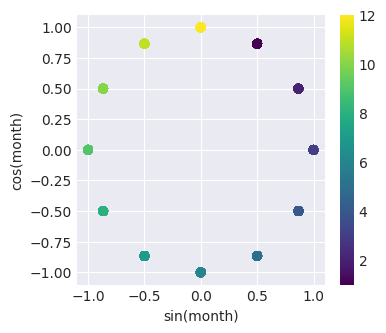

In [8]:
# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(4., 3.5))
sp = ax.scatter(
        data_encoded_sin_cos["month_sin"],
        data_encoded_sin_cos["month_cos"],
        c=data_encoded_sin_cos["month"],
        cmap='viridis'
     )
ax.set(
    xlabel="sin(month)",
    ylabel="cos(month)",
)
_ = fig.colorbar(sp)
data_encoded_sin_cos = data_encoded_sin_cos.drop(columns='month')

## B-splines functions

In [9]:
# Create feature day of year
# ==============================================================================
data['day_of_year'] = data.index.day_of_year
data.head(3)

,y,month,day_of_year
date,,,
2020-01-01,2.928244,1,1
2020-01-02,4.866145,1,2
2020-01-03,4.425159,1,3


In [10]:
# B-spline functions
# ==============================================================================
def spline_transformer(period, degree=3, extrapolation="periodic"):
    """
    Returns a transformer that applies B-spline transformation.
    """
    return SplineTransformer(
                degree=degree,
                n_knots=period+1,
                knots='uniform',
                extrapolation=extrapolation,
                include_bias=True
            ).set_output(transform="pandas")

splines_month = spline_transformer(period=12).fit_transform(data[['day_of_year']])
splines_month.columns = [f"spline{i}" for i in range(len(splines_month.columns))]

The graph below shows the 12 spline functions generated using the day of the year as input. As 12 splines are created with knots evenly distributed along the range 1 to 365 (day_of_year), each curve represents the proximity to the beginning of a particular month.

In [25]:
# Location of the maximum value of each spline
# ==============================================================================
splines_month.idxmax()

0    2020-01-01
1    2020-01-31
2    2020-03-02
3    2020-04-01
4    2020-05-01
5    2020-06-01
6    2020-07-01
7    2020-07-31
8    2020-08-31
9    2020-09-30
10   2020-10-30
11   2020-11-30
dtype: datetime64[ns]

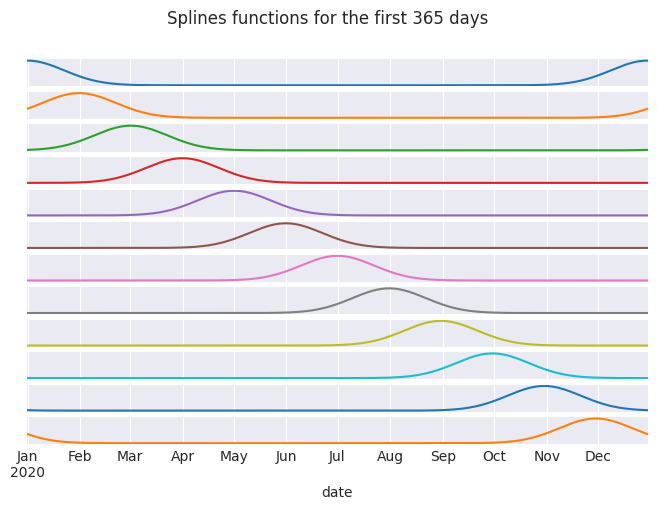

In [24]:
# Plot of the B-splines functions for the first 365 days
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 5))
splines_month.head(365).plot(
    ax       = ax,
    subplots = True,
    sharex   = True,
    legend   = False,
    yticks   = [],
    title    = 'Splines functions for the first 365 days'
);

In [13]:
# Encoded data
# ==============================================================================
data_encoded_splines = pd.concat([data, splines_month], axis=1)
data_encoded_splines = data_encoded_splines.drop(columns=['day_of_year', 'month'])
data_encoded_splines.head(3)

,y,spline0,spline1,spline2,spline3,spline4,spline5,spline6,spline7,spline8,spline9,spline10,spline11
date,,,,,,,,,,,,,
2020-01-01,2.928244,0.166667,0.666667,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,4.866145,0.150763,0.665604,0.183628,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,4.425159,0.135904,0.662485,0.201563,0.000047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Radial basis functions (RBF)

In [28]:
# Radial basis functions
# ==============================================================================
rbf = RepeatingBasisFunction(
            n_periods   = 12,
            remainder   = 'drop',
            column      = 'day_of_year',
            input_range = (1, 365)
        )
rbf.fit(data)
rbf_month = rbf.transform(data)
rbf_month = pd.DataFrame(
                data    = rbf_month,
                index   = data.index,
                columns = [f"rbf_{i}" for i in range(splines_month.shape[1])]
            )
rbf_month.head(3)

,rbf_0,rbf_1,rbf_2,rbf_3,rbf_4,rbf_5,rbf_6,rbf_7,rbf_8,rbf_9,rbf_10,rbf_11
date,,,,,,,,,,,,
2020-01-01,1.000000,0.367879,0.018316,0.000123,1.125352e-07,1.388794e-11,2.319523e-16,1.388794e-11,1.125352e-07,0.000123,0.018316,0.367879
2020-01-02,0.998914,0.392526,0.020875,0.000150,1.463375e-07,1.929034e-11,3.441402e-16,9.976816e-12,8.635293e-08,0.000101,0.016035,0.344032
2020-01-03,0.995662,0.417914,0.023740,0.000183,1.898798e-07,2.673609e-11,5.094813e-16,7.151579e-12,6.611833e-08,0.000083,0.014009,0.321032


In [29]:
# Location of the maximum value of each rbf
# ==============================================================================
rbf_month.idxmax()

rbf_0    2020-01-01
rbf_1    2020-01-31
rbf_2    2020-03-02
rbf_3    2020-04-01
rbf_4    2020-05-01
rbf_5    2020-06-01
rbf_6    2020-07-01
rbf_7    2020-07-31
rbf_8    2020-08-31
rbf_9    2020-09-30
rbf_10   2020-10-30
rbf_11   2020-11-30
dtype: datetime64[ns]

In [30]:
# Encoded data
# ==============================================================================
data_encoded_rbf = pd.concat([data, rbf_month], axis=1)
data_encoded_rbf = data_encoded_rbf.drop(columns=['day_of_year', 'month'])
data_encoded_rbf.head(3)

,y,rbf_0,rbf_1,rbf_2,rbf_3,rbf_4,rbf_5,rbf_6,rbf_7,rbf_8,rbf_9,rbf_10,rbf_11
date,,,,,,,,,,,,,
2020-01-01,2.928244,1.000000,0.367879,0.018316,0.000123,1.125352e-07,1.388794e-11,2.319523e-16,1.388794e-11,1.125352e-07,0.000123,0.018316,0.367879
2020-01-02,4.866145,0.998914,0.392526,0.020875,0.000150,1.463375e-07,1.929034e-11,3.441402e-16,9.976816e-12,8.635293e-08,0.000101,0.016035,0.344032
2020-01-03,4.425159,0.995662,0.417914,0.023740,0.000183,1.898798e-07,2.673609e-11,5.094813e-16,7.151579e-12,6.611833e-08,0.000083,0.014009,0.321032


## Compare forecasting results

A non-informative lag is included so that the impact of cyclical features can be assessed without being obscured by the autoregressive component.

In [32]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags = [70]
             )

Backtest error using one hot encoding: 1.10
Backtest error using sine/cosine encoding: 1.12
Backtest error using spline encoding: 0.75
Backtest error using data_encoded_rbf: 0.74


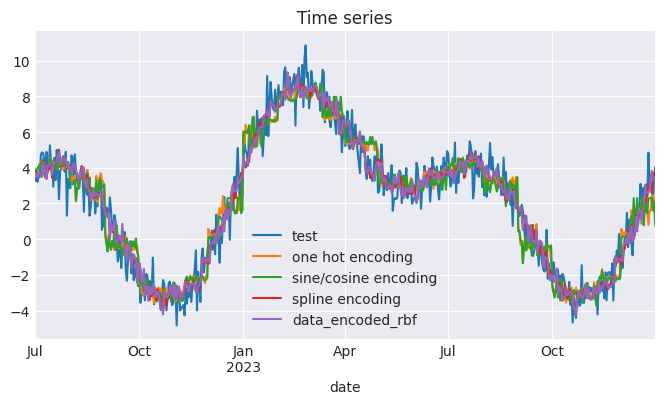

In [33]:
# Train and validate a forecaster using each encoding method
# ==============================================================================
datasets = [data_encoded_oh, data_encoded_sin_cos, data_encoded_splines,
            data_encoded_rbf]
encoding_methods = ['one hot encoding', 'sine/cosine encoding', 'spline encoding',
                    'data_encoded_rbf']
fig, ax = plt.subplots(figsize=(8, 4))
data_test['y'].plot(title="Time series", label="test", ax=ax)

for i, data_encoded in enumerate(datasets):

    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = data_encoded['y'],
                              exog               = data_encoded.drop(columns='y'),
                              initial_train_size = len(data_encoded.loc[:end_train]),
                              fixed_train_size   = False,
                              steps              = 365,
                              refit              = False,
                              metric             = 'mean_squared_error',
                              verbose            = False, # Change to True to see detailed information,
                              show_progress      = False
                          )

    print(f"Backtest error using {encoding_methods[i]}: {metric:.2f}")
    predictions.plot(label=encoding_methods[i], ax=ax)
    ax.legend(labels=['test'] + encoding_methods);

%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>